## K-medias
- Vamos a entrenar un agrupador de K-medias. Intentaremos encontrar el centro de las masas y asignaremos cada instancia a la masa más cercana:

In [2]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [20]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [21]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [22]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

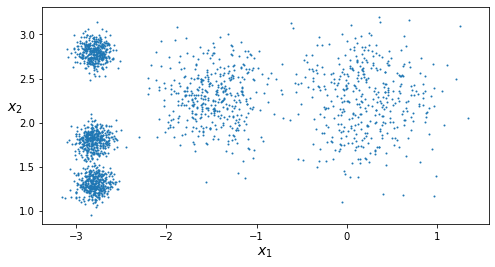

In [24]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

Vamos a intentar encontrar esos grupos con kmeans

In [28]:
k = 5 # Número de grupos que tiene que encontrar
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [29]:
y_pred

array([4, 1, 0, ..., 2, 0, 1])

Cada instancia se ha asignado a uno de los cinco grupos. La instancia Kmeans preserva una coia de las etiquetas de las instancias mediante la variable de instancia labels_:

In [30]:
y_pred is kmeans.labels_

True

El algoritmo ha encontrado cinco centroides:

In [31]:
kmeans.cluster_centers_

array([[ 0.20667809,  2.25769931],
       [-2.80389191,  1.80053039],
       [-2.79290307,  2.79641063],
       [-1.46893704,  2.28372774],
       [-2.8003719 ,  1.30022776]])

Podemos añadir con facilidad nuevas instancias al grupo cuyo centroide esté más cerca:

In [32]:
X_new = np.array([[0,2],[3,2],[-3,3],[3,2.5]])

In [33]:
kmeans.predict(X_new)

array([0, 0, 2, 0])

Podemos trazar los límites de los grupos y obtener una teselación de Voronoi:

In [34]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

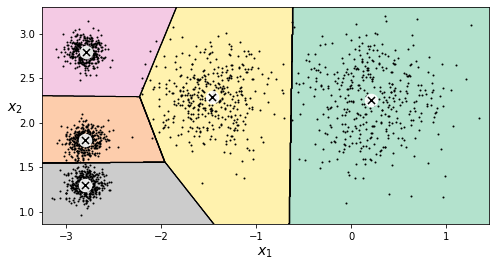

In [35]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

La mayoría se han asignado al grupo adecuado pero algunas se han debido de etiquetar mal. Asigna a grupos en función a la distancia del centroide.
- Agrupamiento duro: asigna una instancia a un solo grupo
- Agrupamiento suave: se da a cada distancia una puntuación por grupo
    - La puntuación puede ser entre la distancia y el centroide
    - A la inversa, puede ser una puntuación de similitud (o afinidad), como la función de base radial gaussiana. 
    
En la clase KMeans, el método transform() mide la distancia desde cada instancia a todos los centroides.

In [36]:
kmeans.transform(X_new)

array([[0.33034038, 2.81097811, 2.9042344 , 1.49608739, 2.88647951],
       [2.80518382, 5.80731861, 5.84739223, 4.47793476, 5.8424306 ],
       [3.29147303, 1.2153953 , 0.29040966, 1.69032533, 1.71145466],
       [2.80381114, 5.84588907, 5.80048146, 4.47416718, 5.92315521]])

ej. la primera instancia se encuentra a una distancia de 0.33 del priemr centroide, 2.81 del segundo,etc.

Si tenemos un conjunto de datos de alta dimensionalidad y lo transformamos de esa forma, obtenemos un conjunto de datos de k dimensiones, por tanto puede ser una téncica de reducción de dimensionalidad no lineal muy eficiente.

## Estudio del algoritmo

- Dados dos centroides, se pueden etiquetar todas las instancias del conjunto de datos asignando cada una de ellas al grupo cuyo centroide esté más cerca.

- A la inversa, si nos diesen todas las etiquetas, podríamos calcular los centroides calculando la media de las instancias de cada grupo.

- En el caso de que no nos den ni las etiquetas ni los centroides:
    - Colocamos los centroides de forma aleatoria
        - Ej. elegimos K instancias al azar y utilizamos sus ubicaciones como centroides
    - A continuación, hasta que los centroides dejen de moverse, hacemos:
        - etiquetamos instancias, actualizamos centroides, etiquetamos instancias, actualizamos centroides, ...
    - El algoritmo convergerá en un número finito de pasos.
    - Aunque está garantizado que el algoritmo convergerá, puede que no converja en la solución adecuada (es decir, puede que converja en un óptimo local), que lo haga o no dependerá de los centroides.

## Ejemplo:

In [37]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

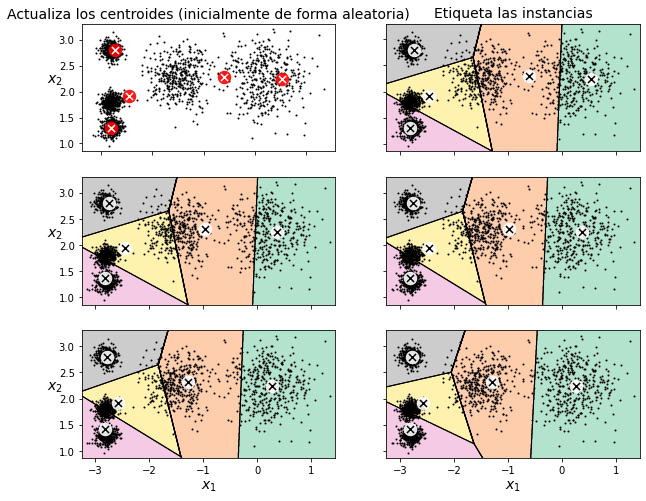

In [40]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Actualiza los centroides (inicialmente de forma aleatoria)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Etiqueta las instancias", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

- Puede ocurrir que obtengamos soluciones NO óptimas debido a inicializaciones de los centroides poco afortunadas.

## Métodos de inicialización de centroides
- Numpy y el hiperparámetro init: si tenemos una idea aproximada de donde están los centroides podemos inicializar un array de numpy con los centriodes y configurar init como 1:

In [43]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1, random_state=42)

- Otra solución es ejecutar el algoritmo varias veces con inicializaciones aleatorias diferentes y mantener la mejor solución.
    - El hiperparámetro init por defecto es 10, significa que se ejecuta 10 veces cuando se llama a fit() y SKLearn mantiene la mejor solución
        - ¿Cuál es la mejor solución?. Utiliza la mecánica de rendimiento, denominada "inercia" del modelo, que es la distancia cuadrática media entre cada instancia y su centroide más próximo.

In [45]:
kmeans.inertia_ # se puede acceder a la inercia a través de inertia_

211.62337889822362

- El método score() devuelve la inercia negativa porque el método score() de un predictor siempre debe respectar la regla de SKLearn de "cuanto más grande, mejor", de forma que si un predictor es mejor que otro, entonces su método score() debería devolver una puntuación mayor:

In [46]:
kmeans.score(X)

-211.6233788982236

- La clase KMeans utiliza una forma eficiente de obtener los centroides propuesta en un artículo en 2006 por David Arthur y Sergei Vassilvitskii.
    - Si queremos obligar a utilizar el método original, podemos establecer el hiperparámetro init a "random".

## K-medias acelerado y Minilote K-Medias

- Charles Elkan introdujo en 2003 otra mejora en el algoritmo explotando la desigualdad triangular(una línea recta siempre es la distancia más corta entre dos puntos) y haciendo un seguimiento de los límites superior e inferior para distancias entre distancias y centroides.
    - Este algorimto lo utiliza KMeans por defecto y se puede forzar a que use el algoritmo por defecto poniendo el hiperparámetro algortihm='full'

- David Sculley introdujo en 2010 otra mejora en donde en vez de utilizar el conjunto de datos entero en cada iteración, el algoritmo es capaz de utilizar minilotes, moviendo los centroides solo un poco en cada iteración. Hace al algoritmo entre 3 y 4 veces más rápido y permite ejecutarlo sobre datos que no caben en memoria:
    - SKLearn implementa este algotimo en la clase MiniBatchMeans

In [48]:
from sklearn.cluster import MiniBatchKMeans

minibatch_means = MiniBatchKMeans(n_clusters=5)

In [49]:
minibatch_means.fit(X)

MiniBatchKMeans(n_clusters=5)

- Si el conjunto de datos no cabe en memoria, la opción más sencilla es utilizar la clase memmap
- Aunque el algoritmo Minilote Kmedias es mucho más rápido que el algoritmo KMedias normal su inercia suele ser peor, sobre todo a medida que aumenta el número de grupos.

## Encontrar el número de grupos óptimo
- La inercia no es una buena métrica de rendimiento cuando intentamos elegir k, porque seguirá bajando a medida que incrementemos k y cuanto más grupos hayam más cerca estará cada instancia de su centroide más próximo y por tanto menor inercia.
- Otra forma de hacerlo con mejor precisión pero más costoso computacionalmente es utilizar la puntuación de silueta, que es el coeficiente medio de la silueta sobre todas las instancias. 
- Coeficiente de silueta de una instancia es a(b-)/max(a,b)
    - a: es la distancia media a la media al grupo más cercano
- El coefiente de silueta varía entre -1 y 1.
    - Cercano a 1 significa que la instancia está muy metida en su propio grupo y lejos de otros grupos
    - Cercano a 0 significa que está cerca del límite del grupo
    - Cercano a -1 significa que la instancia puede haberse asignado al grupo equivocado
- Para calcular la puntuación de la silueta:

In [50]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.6555176425728279

- Para trazar una visualización muy informativa podemos trazar el coeficiente de silueta de cada instancia, ordenado por el grupo al que se asigna y por el valor del coeficiente.
    - Se denomina `diagrama de silueta`:

In [52]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [56]:
from sklearn.metrics import silhouette_score

In [57]:
silhouette_score(X, kmeans.labels_)

0.6555176425728279

In [58]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

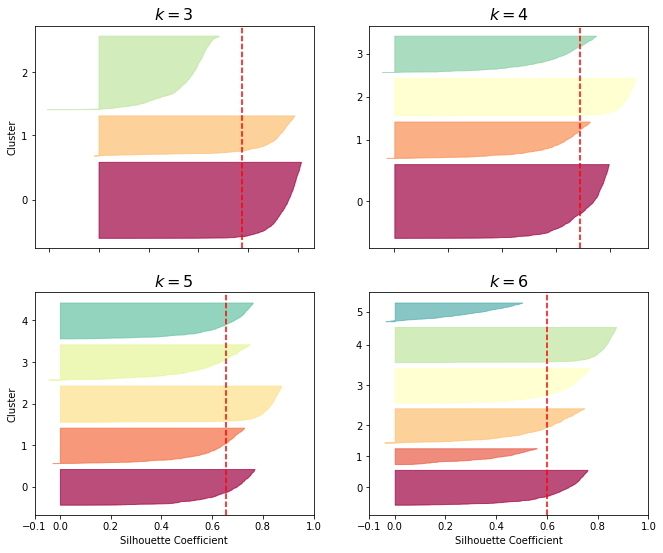

In [59]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

- Las líneas discontinuas verticales representan la puntuación de la silueta para cada número de grupos. Cuando la mayoría de las instancias de un grupo tienen un coeficiente más bajo que esta puntuación, signfica que el grupo es bastate malo dado que sus instancias están demasiado cerca de otros grupos (k=3 y k=6)
- Para k=4 y k=5 está mejor dado que se extienden más hacia la línea discontinua.
- En este caso el resultado más acertado parece k=5 y de esa forma se obtienen grupos de tamaño similar.

## Límite de k-medias

- Hay que ejecutar el algoritmo varias veces para evitar soluciones no óptimas.
- Hay que especificar el número de grupos
- No funciona buen cuando los grupos tienen tamaños variados, densidades diferentes o formas no esféricas

## Usando agrupamiento para la segmentación de imágenes

- La segmentación de imágenes es la tarea de dividir una imagen en múltiples segmentos.
    - Se segmentan píxeles. I.e: una cámara de vigilancia que detecte la etiqueta "personas"
        - Hoy en día se utiliza para esta tarea redes neuronales convolucionales

- En el ejemplo vamos a segmentar por colores.

In [3]:
from matplotlib.image import imread
image = imread(os.path.join("images","ladybug.png"))
image.shape

(533, 800, 3)

- La imagen se representa como una matriz 3D. El tamaño de la primera dimensión es la altura, el segundo es la anchura y el tercero es el número de canales de color (RGB en este caso).

- Cada píxel que hay ahí es un vector 3D que contiene las intensidades RGB definidas entre 0.0 y 1.0 (o entre 0 y 255 si usamos imageio.imread()).

- Algunas imágenes pueden tener más canales como las imágenes con un canal alfa adicional para transparencia o las imágenespor satélite, que contiene canales para muchas frecuencias lumínicas (ej. los infrarrojos).

- El siguiente código remodela la matriz para obtener una lista de colores RGB y seguidamente agrupa esos colores utilizando kmeans.

In [27]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=2).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

- Poe ejemplo, puede que identifique un grupo de color para todos los tonos de verde.
    - A continuación para cada color (por ejemplo, verde oscuro), busca el color medio del grupo de color del píxel.
        - Por último remodela la lista de colores para obtener la misma forma que la imagen original

In [28]:
segmented_img[0]

array([[0.13454524, 0.2662368 , 0.04045005],
       [0.13454524, 0.2662368 , 0.04045005],
       [0.13454524, 0.2662368 , 0.04045005],
       ...,
       [0.13454524, 0.2662368 , 0.04045005],
       [0.13454524, 0.2662368 , 0.04045005],
       [0.13454524, 0.2662368 , 0.04045005]], dtype=float32)

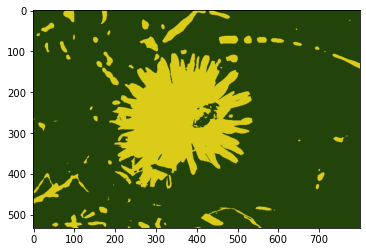

In [29]:
plt.imshow(segmented_img)

In [6]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

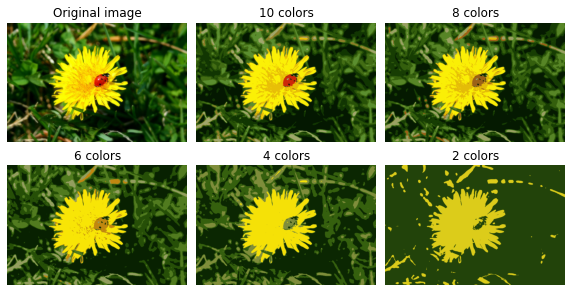

In [7]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

## Utilizar agrupamiento para el preprocesamiento

- El agrupamiento se puede utilizar como paso previo a algoritmos de aprendizaje supervisado, ya que se puede utilizar para reducir la dimensionalidad.

- Como ejemplo de agrupamiento y reducción de dimensionalidad vamos a probar digits, que es un conjunto de datos tipo MNIST que contiene 1797 imágenes 8x8 en escala de grises con dígitos entre 0 y 9:

In [87]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True) # cargamos conjunto de datos

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [62]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [64]:
log_reg.score(X_test, y_test)

0.9688888888888889

- Nuestro punto de referencia será 0,96% de exactitud.
- Vamos a utilizar kmeans como paso de pre-procesamiento
    - Crearemos una pipeline que agrupará el conjunto de entrenamiento en 50 grupos y sustituirá las imñagenes pr sus distancias a esos 50 grupos y después aplicará un modelo de regresión logística:

In [65]:
from sklearn.pipeline import Pipeline

In [68]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [69]:
pipeline.score(X_train, y_train)

0.9970304380103935

- Hemos conseguido reducir la tasa de error de 3% a 1% aprox!

- Pero hemos utilizado un valor de k arbitrario. Para obtener el valor de k idóneo no vamos a utilizar la inercia ni la silueta, vamos a realizar validación cruzada para obtener el mejor rendimiento de clasificación. 
    - Utilizaremos GridSearchCV

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2,100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] 

[CV] ............................ kmeans__n_clusters=22, total=   1.4s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   1.3s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   1.5s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   1.6s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   1.4s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   1.6s
[CV] kmeans__n_clusters=24 ...........................................
[CV] ............................ kmeans__n_clusters=24, total=   1.6s
[CV] kmeans__n_clusters=24 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=41, total=   2.0s
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total=   2.1s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   2.3s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   2.0s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   2.3s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   1.9s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   1.9s
[CV] kmeans__n_clusters=43 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=60, total=   2.4s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   2.7s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   2.5s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   2.5s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   2.6s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   2.4s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   2.6s
[CV] kmeans__n_clusters=63 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=80, total=   2.3s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   2.4s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   2.6s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   2.5s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   2.2s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   3.0s
[CV] kmeans__n_clusters=82 ...........................................
[CV] ............................ kmeans__n_clusters=82, total=   2.6s
[CV] kmeans__n_clusters=82 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=99, total=   2.6s
[CV] kmeans__n_clusters=99 ...........................................
[CV] ............................ kmeans__n_clusters=99, total=   3.4s


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  9.8min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

- Vamos a ver el mejor valor para k y el rendimiento de la pipeline resultante:

In [73]:
grid_clf.best_params_

{'kmeans__n_clusters': 78}

In [74]:
grid_clf.score(X_test, y_test)

0.9844444444444445

- Con k = 99 grupos obtenemos una mejora significativa de la exactitud, que llega al valor 98,45% en el conjunto de pruebas

## Utilizar agrupamiento para aprendizaje semisupervisado

- En aprendizaje semisupervisado tenemos muchas instancias sin etiquetar y muy pocas etiquetadas.

- Primero entrenaremos un modelo de regresión logística en una muestra de 50 instancias etiquetadas del conjunto de datos digits:

In [81]:
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)

In [82]:
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

- ¿Cuál es el rendimiento de este modelo en el conjunto de prueba?

In [84]:
log_reg.score(X_test, y_test)

0.8688888888888889

- La exactitud es del 86,7%. Es más baja que antes pero es normal que al entrenar en el conjunto de prueba de algo menos de exactitud que cuando lo hicimos en el de entrenamiento.
    - ¿cómo podemos mejorar esto?

1. Agrupamos el conjunto de entrenamiento en 50 grupos
2. Para cada grupo, buscamos la imagen más cercana al centroide (imágenes representativas)

In [91]:
k = 50
kmeans = KMeans(n_clusters=k)
X_digit_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digit_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

- Lo visualizamos:

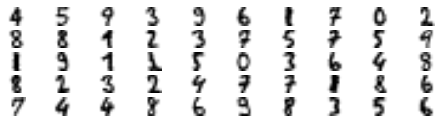

In [92]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

- Vamos a fijarnos en cada imagen y a etiquetarla a mano:

In [94]:
y_representative_digits = np.array([
    4,5,9,3,9,6,1,7,0,2,
    8,8,1,2,3,7,5,7,5,9,
    1,9,1,1,5,0,3,6,4,8,
    8,2,3,2,4,7,7,8,8,6,
    7,4,4,8,6,9,8,3,5,6
])

- Ahora tenemos un conjunto de datos con solo 50 instancias etiquetadas, pero en vez de ser instancias aleatorias, cada una de ellas es una imagen representativa de su grupo.

- ¿Mejora el rendimiento?

In [95]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9133333333333333

- Sí, ha mejorado, hemos pasado de 86,7% a 91,3%, entrenando el modelo únicamente con 50 instancias.

- Estudiemos la operación de `propagar las etiquetas` a todas las demás instancias del mismo grupo:

In [97]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)

for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

- Entrenamos de nuevo el modelo y miramos su rendimiento:

In [98]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9377777777777778

- Aunque hemos obtenido una mejora considerable, tampoco es un rendimiento muy superior. Esto se debe a que hemos propagado la etiqueta de cada instancia representativa a todas la instancias del mismo grupo, incluidas las instancias ubicadas cerca de los límites del grupo, que tienen más probabilidades de etiquetarse mal.
- Vamos a propagar solo al 20% de las instancias que están más cerca de los centroides:

In [145]:
def look_and_train(percentile_closest):

    X_cluster_dist = X_digit_dist[np.arange(len(X_train)), kmeans.labels_]

    for i in range(k):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1

    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = X_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]

    # Entrenamos el modelo otra vez en este conjunto de datos parcialmente propagado:
    log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
    log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
    return log_reg.score(X_test, y_test)

In [147]:
for i in range(100):
    if i%2:
        print(i,look_and_train(i))

1 0.9133333333333333
3 0.9133333333333333
5 0.9177777777777778
7 0.9222222222222223
9 0.9266666666666666
11 0.9155555555555556
13 0.9133333333333333
15 0.9222222222222223
17 0.92
19 0.9177777777777778
21 0.92
23 0.9044444444444445
25 0.9044444444444445
27 0.9066666666666666
29 0.9066666666666666
31 0.9133333333333333
33 0.9155555555555556
35 0.9177777777777778
37 0.9111111111111111
39 0.9066666666666666
41 0.9133333333333333
43 0.9066666666666666
45 0.9088888888888889
47 0.9177777777777778
49 0.9155555555555556
51 0.8977777777777778
53 0.9066666666666666
55 0.9111111111111111
57 0.9111111111111111
59 0.9133333333333333
61 0.9088888888888889
63 0.92
65 0.9177777777777778
67 0.9133333333333333
69 0.9133333333333333
71 0.9155555555555556
73 0.92
75 0.9244444444444444
77 0.9355555555555556
79 0.9333333333333333
81 0.9311111111111111
83 0.9377777777777778
85 0.9355555555555556
87 0.9377777777777778
89 0.9355555555555556
91 0.9377777777777778
93 0.9377777777777778
95 0.94
97 0.93555555555555

- Propagando parcialmente al 95% respecto al centroide tenemos una ganacia de 1%, un 94% de exactitud